In [18]:
import torchvision
import torch
import numpy
import torch.nn as nn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
%matplotlib inline

In [19]:
dataset=MNIST(root="C:",download=True,transform=ToTensor())

torch.Size([1, 28, 28]) 3


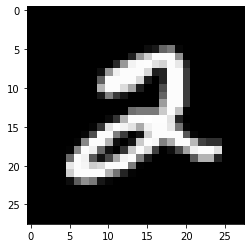

In [20]:
image,lable=dataset[5]
print(image.shape,image.ndim)
plt.imshow(torch.permute(image,(1,2,0)),cmap="gray")

In [21]:
train_ds,val_ds=random_split(dataset,[50000,10000])
train_loader=DataLoader(train_ds,128,shuffle=True)
val_loader=DataLoader(val_ds,128)

torch.Size([128, 1, 28, 28])
torch.Size([242, 482, 3])


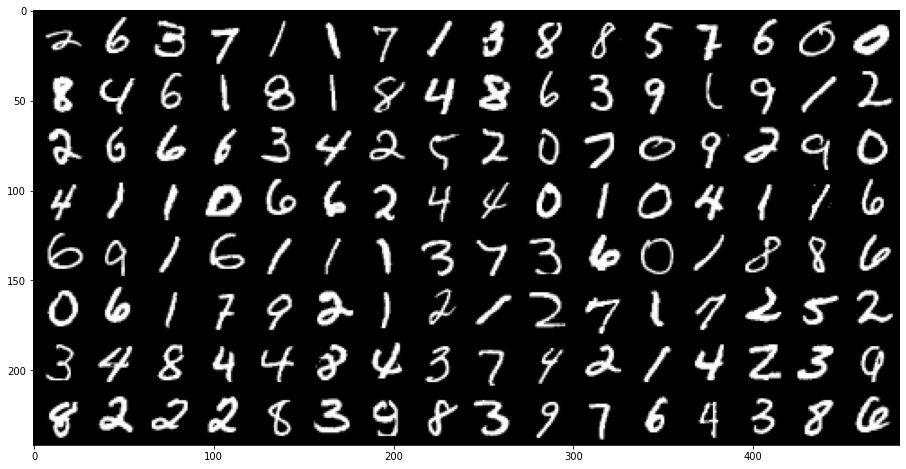

In [22]:
for img,_ in train_loader:
    print(img.shape)
    plt.figure(figsize=(16,8))
    print(make_grid(img,nrow=16).permute(1,2,0).shape)
    plt.imshow(make_grid(img,nrow=16).permute(1,2,0))
    break

In [23]:
def accuracy(out,lab):
    _,preds=torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds==lab).item()/len(preds))

In [24]:
def evaluate(model,val_loader):
    e=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(e)

In [25]:
def fit(epochs,model,lr,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer=opt_func(model.parameters(),lr)
    history=[]

    for epoch in range(epochs):
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        res=evaluate(model,val_loader)
        model.epoch_end(epoch,res)
        history.append(res)
    return history

In [26]:
class amodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(784,64)
        self.layer2=nn.Linear(64,10)
    def forward(self,x):
        x=x.view(x.size(0),-1)
        out=self.layer1(x)
        out=f.relu(out)
        out=self.layer2(out)
        return out
    
    def training_step(self,batch):
        images,lables=batch
        out=self.forward(images)
        loss=f.cross_entropy(out,lables)
        return loss
    
    def validation_step(self,batch):
        images, lables =batch
        out=self.forward(images)
        loss=f.cross_entropy(out,lables)
        acc=accuracy(out,lables)
        return {"val_loss":loss,"val_acc":acc}
    
    def validation_epoch_end(self,out):
        batch_loss=[x["val_loss"] for x in out]
        batch_acc=[x["val_acc"] for x in out]
        epoch_loss=torch.stack(batch_loss).mean()
        epoch_acc=torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch[{}] ,val_loss:{:.4f},val_acc:{:.4f} ".format(epoch,result["val_loss"],result["val_acc"]))
model=amodel()

In [27]:
history1=fit(6,model,0.4,train_loader,val_loader)

Epoch[0] ,val_loss:0.2223,val_acc:0.9352 
Epoch[1] ,val_loss:0.1825,val_acc:0.9466 
Epoch[2] ,val_loss:0.1489,val_acc:0.9563 
Epoch[3] ,val_loss:0.1269,val_acc:0.9626 
Epoch[4] ,val_loss:0.1305,val_acc:0.9603 
Epoch[5] ,val_loss:0.1168,val_acc:0.9659 


In [28]:
history2=fit(6,model,0.1,train_loader,val_loader)

Epoch[0] ,val_loss:0.1047,val_acc:0.9678 
Epoch[1] ,val_loss:0.1040,val_acc:0.9688 
Epoch[2] ,val_loss:0.1032,val_acc:0.9693 
Epoch[3] ,val_loss:0.1017,val_acc:0.9694 
Epoch[4] ,val_loss:0.1024,val_acc:0.9689 
Epoch[5] ,val_loss:0.1014,val_acc:0.9695 


In [29]:
test=MNIST(root="C:",train=False,transform=ToTensor())

In [30]:
def predict(image,lable):
    x=image.unsqueeze(0)
    x=model.forward(x)
    _,preds=torch.max(x,dim=1)
    return preds[0].item()

predicted: 9 Label: 9


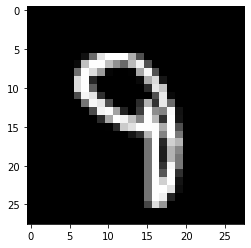

In [31]:
img,lab=test[193]
plt.imshow(img[0],cmap="gray")
print("predicted:",predict(img,lab),"Label:",lab)

predicted: 2 Label: 2


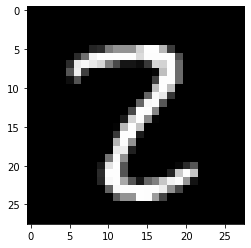

In [32]:
img,lab=test[1839]
plt.imshow(img[0],cmap="gray")
print("predicted:",predict(img,lab),"Label:",lab)

In [33]:
torch.save(model.state_dict(),"Working with MNIST(Non Linear relations).pth")

In [34]:
model2=amodel()
model2.load_state_dict(torch.load("Working with MNIST(Non Linear relations).pth"))
model2.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0321,  0.0229, -0.0036,  ...,  0.0104,  0.0279, -0.0325],
                      [-0.0074,  0.0098,  0.0321,  ...,  0.0121, -0.0023,  0.0106],
                      [ 0.0020, -0.0208,  0.0053,  ...,  0.0074, -0.0345,  0.0053],
                      ...,
                      [ 0.0267,  0.0024, -0.0036,  ..., -0.0165,  0.0312, -0.0039],
                      [ 0.0061,  0.0150, -0.0073,  ..., -0.0341, -0.0202,  0.0132],
                      [ 0.0316, -0.0082, -0.0133,  ...,  0.0252, -0.0187, -0.0234]])),
             ('layer1.bias',
              tensor([ 0.0556,  0.0451,  0.1107,  0.0133, -0.1403,  0.2066,  0.0897, -0.1232,
                      -0.0707,  0.0970,  0.0041,  0.1472,  0.0211,  0.0058, -0.1172,  0.0358,
                      -0.0218, -0.1119,  0.0988, -0.1813,  0.0732, -0.0450,  0.1063,  0.0537,
                       0.2416, -0.0349,  0.0879,  0.3717, -0.0029,  0.1801, -0.0360, -0.2004,
                       0.0110,